# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

# Homework 2 - Unsupervised Deep Learning

Chioccarello Stefano

Student ID: 2011656


In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os 
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
!pip install torchmetrics
import torchmetrics
from torch.utils.data import DataLoader
from IPython.display import Image
from torchvision.utils import save_image
!pip install plotly
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

!pip install pytorch-lightning
!pip install optuna
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import joblib


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


In [3]:
torch.manual_seed(2011656)    
np.random.seed(2011656)
random.seed(2011656)

# Autoencoder with Pytorch-lightning

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Dataset and Dataloader

In [5]:
# Download the training and test datasets
train_dataset = datasets.FashionMNIST(root='FashionMNIST_dataset', train=True, download=True)

test_dataset = datasets.FashionMNIST(root='FashionMNIST_dataset', train=False, download=True)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


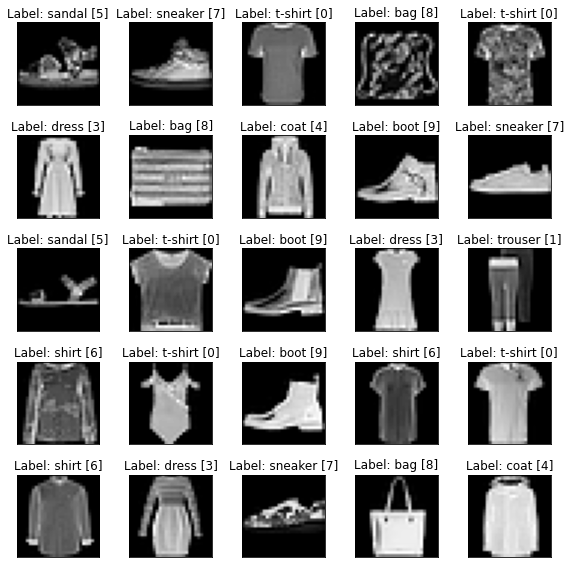

In [6]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [8]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [9]:
train_split, valid_split = torch.utils.data.random_split(train_dataset, [50000,10000])   

print('Train samples:', len(train_split), '\nValidation samples:', len(valid_split), '\nTest samples:', len(test_dataset))

# set up dataloaders
train_dataloader = DataLoader(train_split, batch_size=256, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_split, batch_size=256, shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

Train samples: 50000 
Validation samples: 10000 
Test samples: 10000


In [10]:
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Network Definition

In [11]:
class ConvAutoEncoder(pl.LightningModule):

    def __init__(self, encoded_space_dim):

        super().__init__()
        
               
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Second convolutional layer
                                      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Third convolutional layer
                                      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                                                stride=2, padding=0),
                                      nn.ReLU(True),
                                      nn.Flatten(start_dim=1),
                                      nn.Linear(in_features=3*3*32, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( 
                                      # First linear layer
                                      nn.Linear(in_features=encoded_space_dim, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=32*3*3),
                                      nn.ReLU(True),
                                      nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
                                      ### Convolutional section
                                      nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                                      stride=2, output_padding=0),
                                      nn.ReLU(True),
                                      # Second transposed convolution
                                      nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.ReLU(True),
                                      # Third transposed convolution
                                      nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.Sigmoid()
                                      )
        
    def forward(self, x):
        out = self.encoder(x)
        return out

    def training_step(self, batch, batch_idx):
        # With Pytorch Lightning, training is separated from inference. 
        # The training_step defines the full training loop. 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        loss = nn.MSELoss()
        train_loss = loss(x_dec, x_batch)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        loss = nn.MSELoss()
        val_loss = loss(x_dec, x_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-5)
            
        return optimizer
    
    def set_loss(self, loss_func):
        self.loss_func = loss_func

## Training Loop

In [12]:
net = ConvAutoEncoder(2)

### Check image sizes
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encoder(img)
print('Encoded image shape:', img_enc.shape)
img_enc = net.forward(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

net.to(device)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(in

In [13]:
trainer = pl.Trainer(gpus=1, max_epochs=50, 
                     callbacks=[EarlyStopping(monitor='valid_loss'),
                                pl.callbacks.progress.TQDMProgressBar(refresh_rate=100)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
trainer.fit(net, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.5 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
trainer.test(net, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.03184233233332634}
--------------------------------------------------------------------------------


[{'test_loss': 0.03184233233332634}]

In [16]:
trainer.save_checkpoint("convAutoEnc_checkpoints.ckpt")


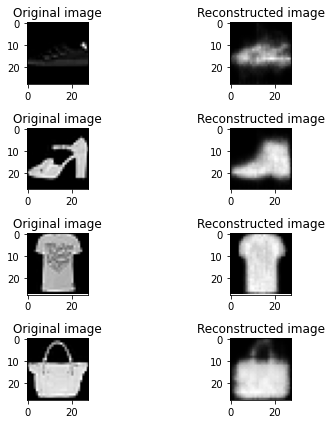

In [17]:
### Plot some samples from test set
net.to(device)
fig, axs = plt.subplots(4, 2, figsize=(8,6))
for  ax in axs:
  img, _ = random.choice(test_dataset)
  img = img.unsqueeze(0).to(device)
  net.eval()
  with torch.no_grad():
    rec_img  = net.decoder(net.encoder(img))
  # Plot the reconstructed image
  ax[0].imshow(img.cpu().squeeze().numpy(),cmap='gist_gray')
  ax[0].set_title('Original image')
  ax[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax[1].set_title('Reconstructed image')
  plt.tight_layout()

## Optuna hyperparameter tuning

In [18]:
class ConvAutoEncoder(pl.LightningModule):

    def __init__(self, trial):

        super().__init__()
        
        # optuna functionality for selecting initial value.                                                                  
        encoded_space_dim = trial.suggest_int('encoded_space_dim', 2, 50) # sampled from the integers in [2,100]
        num_channels = trial.suggest_int('num_channels', 3, 10)

        self.trial = trial
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      nn.Conv2d(in_channels=1, out_channels=num_channels, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Second convolutional layer
                                      nn.Conv2d(in_channels=num_channels, out_channels=2*num_channels, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Third convolutional layer
                                      nn.Conv2d(in_channels=2*num_channels, out_channels=4*num_channels, kernel_size=3, 
                                                stride=2, padding=0),
                                      nn.ReLU(True),
                                      nn.Flatten(start_dim=1),
                                      nn.Linear(in_features=3*3*4*num_channels, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( 
                                      # First linear layer
                                      nn.Linear(in_features=encoded_space_dim, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=4*num_channels*3*3),
                                      nn.ReLU(True),
                                      nn.Unflatten(dim=1, unflattened_size=(4*num_channels, 3, 3)),
                                      ### Convolutional section
                                      nn.ConvTranspose2d(in_channels=4*num_channels, out_channels=2*num_channels, kernel_size=3, 
                                      stride=2, output_padding=0),
                                      nn.ReLU(True),
                                      # Second transposed convolution
                                      nn.ConvTranspose2d(in_channels=2*num_channels, out_channels=num_channels, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.ReLU(True),
                                      # Third transposed convolution
                                      nn.ConvTranspose2d(in_channels=num_channels, out_channels=1, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.Sigmoid()
                                      )
        self.loss_func = nn.MSELoss() 
        
    def forward(self, x):
        out = self.encoder(x)
        return out

    def training_step(self, batch, batch_idx):
        # With Pytorch Lightning, training is separated from inference. 
        # The training_step defines the full training loop. 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        train_loss = self.loss_func(x_dec, x_batch)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        val_loss = self.loss_func(x_dec, x_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        lr  = self.trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        opt = self.trial.suggest_categorical('optimizer', ['sgd', 'Adam'])
        wd  = self.trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
        mom = self.trial.suggest_uniform('momentum', 0.7, 1.)
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)            
        return optimizer

In [19]:
class MetricsCallback(Callback):
  
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)
        

In [20]:
def objective(trial):
  
    metrics_callback = MetricsCallback()
    
    trainer = pl.Trainer( logger=False,
                          max_epochs=50,
                          gpus=1,
                          callbacks=[ metrics_callback, 
                                      PyTorchLightningPruningCallback(trial, monitor="valid_loss")],
                         )

    model = ConvAutoEncoder(trial)
    trainer.fit(model, train_dataloader, valid_dataloader)
    
    return metrics_callback.metrics[-1]["valid_loss"].item()

In [21]:
pruner = optuna.pruners.MedianPruner()

study = optuna.create_study(direction="minimize", pruner=pruner)
loss_func = nn.MSELoss()
study.optimize(objective, n_trials=100, timeout=None)

[I 2022-01-05 10:09:02,045] A new study created in memory with name: no-name-1183e0ef-9c8b-4935-8f2c-f817788795be
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 13.0 K
1 | decoder   | Sequential | 13.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 10:18:35,677] Trial 0 finished with value: 0.06348949670791626 and parameters: {'encoded_space_dim': 34, 'num_channels': 4, 'learning_rate': 0.007040429887104638, 'optimizer': 'Adam', 'weight_decay': 0.0007077374956123454, 'momentum': 0.767025012108491}. Best is trial 0 with value: 0.06348949670791626.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.5 K
1 | decoder   | Sequential | 34.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
69.4 K    Trainable params
0         Non-trainable params
69.4 K    Total params
0.277     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not em

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 10:28:37,038] Trial 1 finished with value: 0.12420924007892609 and parameters: {'encoded_space_dim': 35, 'num_channels': 10, 'learning_rate': 0.004474895151998728, 'optimizer': 'sgd', 'weight_decay': 2.259431818552512e-06, 'momentum': 0.829110848089182}. Best is trial 0 with value: 0.06348949670791626.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.2 K
1 | decoder   | Sequential | 30.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
60.6 K    Trainable params
0         Non-trainable params
60.6 K    Total params
0.243     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not em

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 10:38:39,471] Trial 2 finished with value: 0.0282824095338583 and parameters: {'encoded_space_dim': 30, 'num_channels': 9, 'learning_rate': 2.0277957881160874e-05, 'optimizer': 'Adam', 'weight_decay': 1.8059327446066168e-06, 'momentum': 0.9349557291596998}. Best is trial 2 with value: 0.0282824095338583.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 10.7 K
1 | decoder   | Sequential | 10.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
21.4 K    Trainable params
0         Non-trainable params
21.4 K    Total params
0.086     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 10:47:57,355] Trial 3 finished with value: 0.0887010470032692 and parameters: {'encoded_space_dim': 44, 'num_channels': 3, 'learning_rate': 1.3101169065766046e-05, 'optimizer': 'Adam', 'weight_decay': 0.00016474687870277546, 'momentum': 0.955253472942869}. Best is trial 2 with value: 0.0282824095338583.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.1 K
1 | decoder   | Sequential | 15.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.122     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not e

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 10:57:23,359] Trial 4 finished with value: 0.14927056431770325 and parameters: {'encoded_space_dim': 19, 'num_channels': 5, 'learning_rate': 3.344841839427467e-05, 'optimizer': 'sgd', 'weight_decay': 4.317629163270243e-05, 'momentum': 0.9016718193233902}. Best is trial 2 with value: 0.0282824095338583.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.6 K
1 | decoder   | Sequential | 27.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not em

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 10:57:23,527] Trial 5 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.3 K
1 | decoder   | Sequential | 31.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model pa

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:07:24,071] Trial 6 finished with value: 0.0180131234228611 and parameters: {'encoded_space_dim': 47, 'num_channels': 9, 'learning_rate': 0.00012075972514011531, 'optimizer': 'Adam', 'weight_decay': 1.4842810097337201e-05, 'momentum': 0.7076526113573278}. Best is trial 6 with value: 0.0180131234228611.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 9.7 K 
1 | decoder   | Sequential | 9.8 K 
2 | loss_func | MSELoss    | 0     
-----------------------------------------
19.5 K    Trainable params
0         Non-trainable params
19.5 K    Total params
0.078     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:16:41,323] Trial 7 finished with value: 0.015569961629807949 and parameters: {'encoded_space_dim': 29, 'num_channels': 3, 'learning_rate': 0.005979032924492004, 'optimizer': 'Adam', 'weight_decay': 9.977306610980574e-06, 'momentum': 0.9770693876903632}. Best is trial 7 with value: 0.015569961629807949.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 23.1 K
1 | decoder   | Sequential | 23.2 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
46.3 K    Trainable params
0         Non-trainable params
46.3 K    Total params
0.185     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 11:16:41,510] Trial 8 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 33.0 K
1 | decoder   | Sequential | 33.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model pa

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 11:16:41,688] Trial 9 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.3 K
1 | decoder   | Sequential | 15.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
30.7 K    Trainable params
0         Non-trainable params
30.7 K    Total params
0.123     Total estimated model pa

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:26:11,645] Trial 10 finished with value: 0.014558111317455769 and parameters: {'encoded_space_dim': 21, 'num_channels': 5, 'learning_rate': 0.001469731471096655, 'optimizer': 'Adam', 'weight_decay': 5.494911327237717e-06, 'momentum': 0.9969662014037294}. Best is trial 10 with value: 0.014558111317455769.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.1 K
1 | decoder   | Sequential | 15.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.122     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is n

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:35:40,321] Trial 11 finished with value: 0.014212123118340969 and parameters: {'encoded_space_dim': 19, 'num_channels': 5, 'learning_rate': 0.001696027103992222, 'optimizer': 'Adam', 'weight_decay': 3.0851827859417603e-06, 'momentum': 0.9965245611441305}. Best is trial 11 with value: 0.014212123118340969.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.4 K
1 | decoder   | Sequential | 18.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
37.0 K    Trainable params
0         Non-trainable params
37.0 K    Total params
0.148     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:45:16,594] Trial 12 finished with value: 0.013982118107378483 and parameters: {'encoded_space_dim': 18, 'num_channels': 6, 'learning_rate': 0.0013181809282394943, 'optimizer': 'Adam', 'weight_decay': 4.851213865034115e-06, 'momentum': 0.9976126280448455}. Best is trial 12 with value: 0.013982118107378483.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 17.5 K
1 | decoder   | Sequential | 17.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
35.3 K    Trainable params
0         Non-trainable params
35.3 K    Total params
0.141     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 11:54:52,677] Trial 13 finished with value: 0.018511049449443817 and parameters: {'encoded_space_dim': 5, 'num_channels': 6, 'learning_rate': 0.0014493141955285614, 'optimizer': 'Adam', 'weight_decay': 1.0168092259134105e-06, 'momentum': 0.9175823130835186}. Best is trial 12 with value: 0.013982118107378483.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.3 K
1 | decoder   | Sequential | 18.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
36.7 K    Trainable params
0         Non-trainable params
36.7 K    Total params
0.147     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 11:54:52,866] Trial 14 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 21.4 K
1 | decoder   | Sequential | 21.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 11:54:53,058] Trial 15 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.5 K
1 | decoder   | Sequential | 15.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:04:21,961] Trial 16 finished with value: 0.012825410813093185 and parameters: {'encoded_space_dim': 24, 'num_channels': 5, 'learning_rate': 0.0026652600537604085, 'optimizer': 'Adam', 'weight_decay': 3.8038314812804586e-06, 'momentum': 0.8799094144779258}. Best is trial 16 with value: 0.012825410813093185.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 12.5 K
1 | decoder   | Sequential | 12.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:04:22,142] Trial 17 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 17.4 K
1 | decoder   | Sequential | 17.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.140     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:04:22,344] Trial 18 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 11.6 K
1 | decoder   | Sequential | 11.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
23.4 K    Trainable params
0         Non-trainable params
23.4 K    Total params
0.093     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:04:44,975] Trial 19 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.0 K
1 | decoder   | Sequential | 27.2 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.2 K    Trainable params
0         Non-trainable params
54.2 K    Total params
0.217     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:14:33,894] Trial 20 finished with value: 0.010624445043504238 and parameters: {'encoded_space_dim': 40, 'num_channels': 8, 'learning_rate': 0.0029497869977294392, 'optimizer': 'Adam', 'weight_decay': 3.178412949421967e-06, 'momentum': 0.7103568901817146}. Best is trial 20 with value: 0.010624445043504238.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 25.9 K
1 | decoder   | Sequential | 26.2 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
52.1 K    Trainable params
0         Non-trainable params
52.1 K    Total params
0.208     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:14:34,084] Trial 21 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.1 K
1 | decoder   | Sequential | 27.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.4 K    Trainable params
0         Non-trainable params
54.4 K    Total params
0.218     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:24:22,602] Trial 22 finished with value: 0.014013204723596573 and parameters: {'encoded_space_dim': 42, 'num_channels': 8, 'learning_rate': 0.0008414395155225835, 'optimizer': 'Adam', 'weight_decay': 8.256746233974968e-06, 'momentum': 0.749778733795964}. Best is trial 20 with value: 0.010624445043504238.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 23.2 K
1 | decoder   | Sequential | 23.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
46.7 K    Trainable params
0         Non-trainable params
46.7 K    Total params
0.187     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is n

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:24:22,826] Trial 23 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.9 K
1 | decoder   | Sequential | 16.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:33:49,438] Trial 24 finished with value: 0.01189381256699562 and parameters: {'encoded_space_dim': 31, 'num_channels': 5, 'learning_rate': 0.009422186123664735, 'optimizer': 'Adam', 'weight_decay': 3.3458612030387462e-06, 'momentum': 0.7394701906761487}. Best is trial 20 with value: 0.010624445043504238.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.9 K
1 | decoder   | Sequential | 16.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is n

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:33:49,629] Trial 25 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 13.3 K
1 | decoder   | Sequential | 13.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
26.7 K    Trainable params
0         Non-trainable params
26.7 K    Total params
0.107     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:34:11,935] Trial 26 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 29.8 K
1 | decoder   | Sequential | 30.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
59.9 K    Trainable params
0         Non-trainable params
59.9 K    Total params
0.239     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:44:09,569] Trial 27 finished with value: 0.010614313185214996 and parameters: {'encoded_space_dim': 24, 'num_channels': 9, 'learning_rate': 0.004304137331419038, 'optimizer': 'Adam', 'weight_decay': 1.8115960038041637e-06, 'momentum': 0.7797014758877885}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.3 K
1 | decoder   | Sequential | 30.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
60.9 K    Trainable params
0         Non-trainable params
60.9 K    Total params
0.244     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:09,755] Trial 28 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.8 K
1 | decoder   | Sequential | 27.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
53.8 K    Trainable params
0         Non-trainable params
53.8 K    Total params
0.215     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:10,175] Trial 29 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.1 K
1 | decoder   | Sequential | 30.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
60.4 K    Trainable params
0         Non-trainable params
60.4 K    Total params
0.241     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:10,371] Trial 30 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 33.8 K
1 | decoder   | Sequential | 34.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:10,572] Trial 31 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 22.9 K
1 | decoder   | Sequential | 23.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
45.9 K    Trainable params
0         Non-trainable params
45.9 K    Total params
0.184     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:10,780] Trial 32 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.0 K
1 | decoder   | Sequential | 30.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Total params
0.241     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:10,991] Trial 33 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.5 K
1 | decoder   | Sequential | 15.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:11,176] Trial 34 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 10.7 K
1 | decoder   | Sequential | 10.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
21.4 K    Trainable params
0         Non-trainable params
21.4 K    Total params
0.086     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:11,392] Trial 35 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.7 K
1 | decoder   | Sequential | 26.9 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
53.5 K    Trainable params
0         Non-trainable params
53.5 K    Total params
0.214     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:11,608] Trial 36 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 16.6 K
1 | decoder   | Sequential | 16.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
33.3 K    Trainable params
0         Non-trainable params
33.3 K    Total params
0.133     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:11,806] Trial 37 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.2 K
1 | decoder   | Sequential | 34.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
68.7 K    Trainable params
0         Non-trainable params
68.7 K    Total params
0.275     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:12,003] Trial 38 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 13.8 K
1 | decoder   | Sequential | 13.9 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
27.8 K    Trainable params
0         Non-trainable params
27.8 K    Total params
0.111     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:12,209] Trial 39 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 29.7 K
1 | decoder   | Sequential | 29.9 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
59.6 K    Trainable params
0         Non-trainable params
59.6 K    Total params
0.238     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:12,408] Trial 40 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.3 K
1 | decoder   | Sequential | 18.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
36.8 K    Trainable params
0         Non-trainable params
36.8 K    Total params
0.147     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:12,642] Trial 41 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.5 K
1 | decoder   | Sequential | 18.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
37.1 K    Trainable params
0         Non-trainable params
37.1 K    Total params
0.148     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:12,838] Trial 42 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.6 K
1 | decoder   | Sequential | 18.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
37.4 K    Trainable params
0         Non-trainable params
37.4 K    Total params
0.149     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:13,043] Trial 43 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 14.9 K
1 | decoder   | Sequential | 15.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:13,258] Trial 44 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 22.4 K
1 | decoder   | Sequential | 22.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
45.0 K    Trainable params
0         Non-trainable params
45.0 K    Total params
0.180     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:13,469] Trial 45 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 15.1 K
1 | decoder   | Sequential | 15.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.122     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:44:36,370] Trial 46 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 22.6 K
1 | decoder   | Sequential | 22.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
45.4 K    Trainable params
0         Non-trainable params
45.4 K    Total params
0.182     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:36,598] Trial 47 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.8 K
1 | decoder   | Sequential | 19.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.151     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:36,795] Trial 48 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 11.4 K
1 | decoder   | Sequential | 11.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
22.9 K    Trainable params
0         Non-trainable params
22.9 K    Total params
0.091     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:36,994] Trial 49 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 25.3 K
1 | decoder   | Sequential | 25.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
50.8 K    Trainable params
0         Non-trainable params
50.8 K    Total params
0.203     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:44:37,201] Trial 50 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.1 K
1 | decoder   | Sequential | 27.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.4 K    Trainable params
0         Non-trainable params
54.4 K    Total params
0.218     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:45:00,911] Trial 51 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.4 K
1 | decoder   | Sequential | 31.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
63.1 K    Trainable params
0         Non-trainable params
63.1 K    Total params
0.252     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:45:01,108] Trial 52 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.2 K
1 | decoder   | Sequential | 27.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.6 K    Trainable params
0         Non-trainable params
54.6 K    Total params
0.218     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:54:51,042] Trial 53 finished with value: 0.012201497331261635 and parameters: {'encoded_space_dim': 43, 'num_channels': 8, 'learning_rate': 0.0013084338343178738, 'optimizer': 'Adam', 'weight_decay': 1.646444972152787e-05, 'momentum': 0.7004586889964671}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 17.0 K
1 | decoder   | Sequential | 17.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.136     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:51,249] Trial 54 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.8 K
1 | decoder   | Sequential | 35.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
69.9 K    Trainable params
0         Non-trainable params
69.9 K    Total params
0.280     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:51,481] Trial 55 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.2 K
1 | decoder   | Sequential | 31.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.6 K    Trainable params
0         Non-trainable params
62.6 K    Total params
0.250     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:51,690] Trial 56 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 23.1 K
1 | decoder   | Sequential | 23.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
46.4 K    Trainable params
0         Non-trainable params
46.4 K    Total params
0.186     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:51,906] Trial 57 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.6 K
1 | decoder   | Sequential | 26.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
53.4 K    Trainable params
0         Non-trainable params
53.4 K    Total params
0.214     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:52,108] Trial 58 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.3 K
1 | decoder   | Sequential | 18.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
36.8 K    Trainable params
0         Non-trainable params
36.8 K    Total params
0.147     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:52,301] Trial 59 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 21.5 K
1 | decoder   | Sequential | 21.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
43.2 K    Trainable params
0         Non-trainable params
43.2 K    Total params
0.173     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 12:54:52,496] Trial 60 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.1 K
1 | decoder   | Sequential | 27.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.4 K    Trainable params
0         Non-trainable params
54.4 K    Total params
0.218     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 12:55:16,085] Trial 61 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.4 K
1 | decoder   | Sequential | 27.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.220     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:05:04,625] Trial 62 finished with value: 0.012953518889844418 and parameters: {'encoded_space_dim': 46, 'num_channels': 8, 'learning_rate': 0.0011296502819421266, 'optimizer': 'Adam', 'weight_decay': 8.224215896750235e-06, 'momentum': 0.7499263870788404}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.2 K
1 | decoder   | Sequential | 27.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:14:51,543] Trial 63 finished with value: 0.01248668972402811 and parameters: {'encoded_space_dim': 44, 'num_channels': 8, 'learning_rate': 0.0016172309587777316, 'optimizer': 'Adam', 'weight_decay': 4.9624419905551405e-06, 'momentum': 0.7446308566270334}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.6 K
1 | decoder   | Sequential | 27.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:14:51,734] Trial 64 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.2 K
1 | decoder   | Sequential | 31.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.6 K    Trainable params
0         Non-trainable params
62.6 K    Total params
0.250     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:14:51,952] Trial 65 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.6 K
1 | decoder   | Sequential | 27.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.5 K    Trainable params
0         Non-trainable params
55.5 K    Total params
0.222     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:24:38,326] Trial 66 finished with value: 0.012828074395656586 and parameters: {'encoded_space_dim': 50, 'num_channels': 8, 'learning_rate': 0.0011352862435731826, 'optimizer': 'Adam', 'weight_decay': 3.5210960369188542e-06, 'momentum': 0.7311489285021407}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.5 K
1 | decoder   | Sequential | 31.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
63.2 K    Trainable params
0         Non-trainable params
63.2 K    Total params
0.253     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:24:38,519] Trial 67 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 10.7 K
1 | decoder   | Sequential | 10.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
21.4 K    Trainable params
0         Non-trainable params
21.4 K    Total params
0.086     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:25:00,944] Trial 68 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.9 K
1 | decoder   | Sequential | 27.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
53.9 K    Trainable params
0         Non-trainable params
53.9 K    Total params
0.216     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:25:01,177] Trial 69 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 23.3 K
1 | decoder   | Sequential | 23.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
46.8 K    Trainable params
0         Non-trainable params
46.8 K    Total params
0.187     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:25:01,379] Trial 70 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.4 K
1 | decoder   | Sequential | 27.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.0 K    Trainable params
0         Non-trainable params
55.0 K    Total params
0.220     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:25:01,579] Trial 71 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.5 K
1 | decoder   | Sequential | 27.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.2 K    Trainable params
0         Non-trainable params
55.2 K    Total params
0.221     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:25:01,808] Trial 72 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.0 K
1 | decoder   | Sequential | 31.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.3 K    Trainable params
0         Non-trainable params
62.3 K    Total params
0.249     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:25:02,006] Trial 73 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.6 K
1 | decoder   | Sequential | 27.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
55.5 K    Trainable params
0         Non-trainable params
55.5 K    Total params
0.222     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:34:48,252] Trial 74 finished with value: 0.012618822045624256 and parameters: {'encoded_space_dim': 50, 'num_channels': 8, 'learning_rate': 0.0011341230760464908, 'optimizer': 'Adam', 'weight_decay': 6.671423718657059e-06, 'momentum': 0.7319522899889509}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.5 K
1 | decoder   | Sequential | 31.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
63.2 K    Trainable params
0         Non-trainable params
63.2 K    Total params
0.253     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:34:48,466] Trial 75 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 35.4 K
1 | decoder   | Sequential | 35.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
71.0 K    Trainable params
0         Non-trainable params
71.0 K    Total params
0.284     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:34:48,657] Trial 76 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 22.1 K
1 | decoder   | Sequential | 22.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.177     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:34:48,875] Trial 77 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.1 K
1 | decoder   | Sequential | 26.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:34:49,076] Trial 78 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.0 K
1 | decoder   | Sequential | 31.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.3 K    Trainable params
0         Non-trainable params
62.3 K    Total params
0.249     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:44:47,335] Trial 79 finished with value: 0.010632531717419624 and parameters: {'encoded_space_dim': 43, 'num_channels': 9, 'learning_rate': 0.0031723238185203772, 'optimizer': 'Adam', 'weight_decay': 3.7267488239998275e-06, 'momentum': 0.7830600187981526}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.8 K
1 | decoder   | Sequential | 31.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 13:44:47,549] Trial 80 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 27.2 K
1 | decoder   | Sequential | 27.4 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
54.6 K    Trainable params
0         Non-trainable params
54.6 K    Total params
0.218     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 13:54:33,924] Trial 81 finished with value: 0.010977793484926224 and parameters: {'encoded_space_dim': 43, 'num_channels': 8, 'learning_rate': 0.00440212549295575, 'optimizer': 'Adam', 'weight_decay': 3.6592953769379785e-06, 'momentum': 0.786494318862882}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.0 K
1 | decoder   | Sequential | 31.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.3 K    Trainable params
0         Non-trainable params
62.3 K    Total params
0.249     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is no

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:04:31,084] Trial 82 finished with value: 0.010687528178095818 and parameters: {'encoded_space_dim': 43, 'num_channels': 9, 'learning_rate': 0.004047804600245738, 'optimizer': 'Adam', 'weight_decay': 4.2676320489575706e-06, 'momentum': 0.7817415277208883}. Best is trial 27 with value: 0.010614313185214996.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 35.1 K
1 | decoder   | Sequential | 35.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
70.4 K    Trainable params
0         Non-trainable params
70.4 K    Total params
0.282     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:04:31,283] Trial 83 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.9 K
1 | decoder   | Sequential | 31.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:04:31,499] Trial 84 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.6 K
1 | decoder   | Sequential | 30.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.4 K    Trainable params
0         Non-trainable params
61.4 K    Total params
0.246     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:14:28,559] Trial 85 finished with value: 0.01015246007591486 and parameters: {'encoded_space_dim': 36, 'num_channels': 9, 'learning_rate': 0.004361229730260815, 'optimizer': 'Adam', 'weight_decay': 2.814524018765284e-06, 'momentum': 0.7902778305819645}. Best is trial 85 with value: 0.01015246007591486.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.5 K
1 | decoder   | Sequential | 30.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.3 K    Trainable params
0         Non-trainable params
61.3 K    Total params
0.245     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:14:28,754] Trial 86 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.2 K
1 | decoder   | Sequential | 30.5 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
60.8 K    Trainable params
0         Non-trainable params
60.8 K    Total params
0.243     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:14:28,956] Trial 87 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.7 K
1 | decoder   | Sequential | 35.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
69.6 K    Trainable params
0         Non-trainable params
69.6 K    Total params
0.278     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:15:04,745] Trial 88 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.9 K
1 | decoder   | Sequential | 31.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:25:00,946] Trial 89 finished with value: 0.010157360695302486 and parameters: {'encoded_space_dim': 41, 'num_channels': 9, 'learning_rate': 0.0033294674716970833, 'optimizer': 'Adam', 'weight_decay': 2.5634587791232198e-06, 'momentum': 0.8212366486159018}. Best is trial 85 with value: 0.01015246007591486.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.9 K
1 | decoder   | Sequential | 35.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
70.0 K    Trainable params
0         Non-trainable params
70.0 K    Total params
0.280     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is 

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:25:01,130] Trial 90 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 31.0 K
1 | decoder   | Sequential | 31.3 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.3 K    Trainable params
0         Non-trainable params
62.3 K    Total params
0.249     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:25:01,330] Trial 91 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.9 K
1 | decoder   | Sequential | 31.1 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:25:01,534] Trial 92 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.6 K
1 | decoder   | Sequential | 30.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.4 K    Trainable params
0         Non-trainable params
61.4 K    Total params
0.246     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:34:58,488] Trial 93 finished with value: 0.01093236543238163 and parameters: {'encoded_space_dim': 36, 'num_channels': 9, 'learning_rate': 0.004153002471081337, 'optimizer': 'Adam', 'weight_decay': 3.7858532514950844e-06, 'momentum': 0.7993061188225573}. Best is trial 85 with value: 0.01015246007591486.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.4 K
1 | decoder   | Sequential | 30.6 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is no

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:34:58,673] Trial 94 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 34.6 K
1 | decoder   | Sequential | 34.9 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
69.5 K    Trainable params
0         Non-trainable params
69.5 K    Total params
0.278     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:34:58,873] Trial 95 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.7 K
1 | decoder   | Sequential | 31.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:34:59,106] Trial 96 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.8 K
1 | decoder   | Sequential | 31.0 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.8 K    Trainable params
0         Non-trainable params
61.8 K    Total params
0.247     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:34:59,304] Trial 97 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.5 K
1 | decoder   | Sequential | 30.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.3 K    Trainable params
0         Non-trainable params
61.3 K    Total params
0.245     Total estimated model p

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-05 14:44:55,473] Trial 98 finished with value: 0.010794740170240402 and parameters: {'encoded_space_dim': 35, 'num_channels': 9, 'learning_rate': 0.005302698537338047, 'optimizer': 'Adam', 'weight_decay': 2.566432771373413e-06, 'momentum': 0.7931414445465399}. Best is trial 85 with value: 0.01015246007591486.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.4 K
1 | decoder   | Sequential | 30.7 K
2 | loss_func | MSELoss    | 0     
-----------------------------------------
61.1 K    Trainable params
0         Non-trainable params
61.1 K    Total params
0.245     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/jupyter/checkpoints exists and is no

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
[I 2022-01-05 14:44:55,663] Trial 99 pruned. Trial was pruned at epoch 0.


In [22]:
joblib.dump(study, "autoencoder_tuning.pkl")

['autoencoder_tuning.pkl']

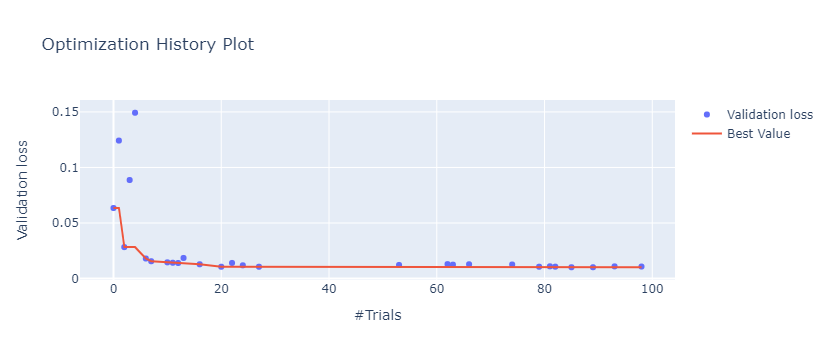

In [23]:
optuna.visualization.plot_optimization_history(study, target_name='Validation loss')

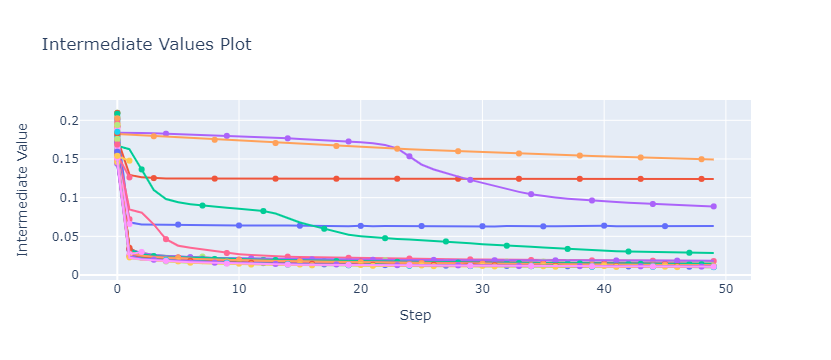

In [24]:
optuna.visualization.plot_intermediate_values(study)

In [25]:
best_trial = study.best_trial
best_params = best_trial.params

print('Best trial:')
print('Value: ', best_trial.value)

print('Best network parameters: ')
for key, value in best_params.items():
    print(f'    {key}: {value}')


Best trial:
Value:  0.01015246007591486
Best network parameters: 
    encoded_space_dim: 36
    num_channels: 9
    learning_rate: 0.004361229730260815
    optimizer: Adam
    weight_decay: 2.814524018765284e-06
    momentum: 0.7902778305819645


## Best network after tuning

In [26]:
class ConvAutoEncoder(pl.LightningModule):

    def __init__(self, params):

        super().__init__()
        
        # optuna functionality for selecting initial value.                                                                  
        encoded_space_dim = params['encoded_space_dim'] 
        num_channels = params['num_channels']
        self.params = params
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      nn.Conv2d(in_channels=1, out_channels=num_channels, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Second convolutional layer
                                      nn.Conv2d(in_channels=num_channels, out_channels=2*num_channels, kernel_size=3, 
                                                stride=2, padding=1),
                                      nn.ReLU(True),
                                      # Third convolutional layer
                                      nn.Conv2d(in_channels=2*num_channels, out_channels=4*num_channels, kernel_size=3, 
                                                stride=2, padding=0),
                                      nn.ReLU(True),
                                      nn.Flatten(start_dim=1),
                                      nn.Linear(in_features=3*3*4*num_channels, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( 
                                      # First linear layer
                                      nn.Linear(in_features=encoded_space_dim, out_features=64),
                                      nn.ReLU(True),
                                      # Second linear layer
                                      nn.Linear(in_features=64, out_features=4*num_channels*3*3),
                                      nn.ReLU(True),
                                      nn.Unflatten(dim=1, unflattened_size=(4*num_channels, 3, 3)),
                                      ### Convolutional section
                                      nn.ConvTranspose2d(in_channels=4*num_channels, out_channels=2*num_channels, kernel_size=3, 
                                      stride=2, output_padding=0),
                                      nn.ReLU(True),
                                      # Second transposed convolution
                                      nn.ConvTranspose2d(in_channels=2*num_channels, out_channels=num_channels, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.ReLU(True),
                                      # Third transposed convolution
                                      nn.ConvTranspose2d(in_channels=num_channels, out_channels=1, kernel_size=3, 
                                                        stride=2, padding=1, output_padding=1),
                                      nn.Sigmoid()
                                      )
        
    def forward(self, x):
        out = self.encoder(x)
        return out

    def training_step(self, batch, batch_idx):
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        loss = nn.MSELoss()
        train_loss = loss(x_dec, x_batch)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_dec = self.decoder(x_enc)
        loss = nn.MSELoss()
        val_loss = loss(x_dec, x_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        lr  = self.params['learning_rate']
        opt = self.params['optimizer']
        wd  = self.params['weight_decay']
        mom = self.params['momentum']
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)            
        return optimizer

In [27]:
bestConvAutoEnc = ConvAutoEncoder(best_params)

### Check image sizes
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = bestConvAutoEnc.encoder(img)
print('Encoded image shape:', img_enc.shape)
img_enc = bestConvAutoEnc.forward(img)
print('Encoded image shape (forward pass):', img_enc.shape)
# Decode the image
dec_img = bestConvAutoEnc.decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 36])
Encoded image shape (forward pass): torch.Size([1, 36])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [28]:
# Move both the encoder and the decoder to the selected device
bestConvAutoEnc.to(device)

trainer = pl.Trainer(gpus=1, max_epochs=100, 
                     callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=100)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [29]:
trainer.fit(bestConvAutoEnc, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 30.6 K
1 | decoder | Sequential | 30.8 K
---------------------------------------
61.4 K    Trainable params
0         Non-trainable params
61.4 K    Total params
0.246     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
trainer.save_checkpoint("best_net.ckpt")

In [31]:
trainer.test(bestConvAutoEnc, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.00917052011936903}
--------------------------------------------------------------------------------


[{'test_loss': 0.00917052011936903}]

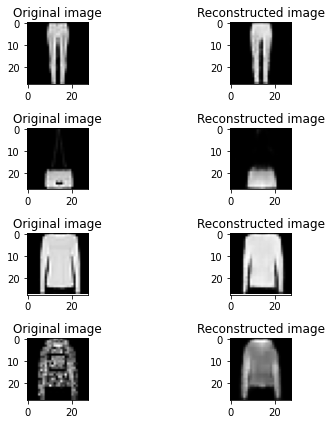

In [34]:
### Plot some samples from test set
bestConvAutoEnc.to(device)
fig, axs = plt.subplots(4, 2, figsize=(8,6))
for  ax in axs:
  img, _ = random.choice(test_dataset)
  img = img.unsqueeze(0).to(device)
  net.eval()
  with torch.no_grad():
    rec_img  = bestConvAutoEnc.decoder(bestConvAutoEnc.encoder(img))
  # Plot the reconstructed image
  ax[0].imshow(img.cpu().squeeze().numpy(),cmap='gist_gray')
  ax[0].set_title('Original image')
  ax[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax[1].set_title('Reconstructed image')
  plt.tight_layout()

## Fine tuning using supervised classification

In [35]:
class Supervised_AE(pl.LightningModule):
    
    def __init__(self, ae_net, params):

        super().__init__()

        self.params = params
       

        self.encoder = ae_net.encoder

        self.classifier = nn.Sequential(
                                        nn.Linear(in_features=params['encoded_space_dim'], out_features=64),
                                        nn.ReLU(True),
                                        nn.Linear(in_features=64, out_features=10)
                                        )

        self.accuracy = torchmetrics.Accuracy()
            
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_class = self.classifier(x_enc)
        loss = nn.CrossEntropyLoss()
        train_loss = loss(x_class, label_batch)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_class = self.classifier(x_enc)
        loss = nn.CrossEntropyLoss()
        val_loss = loss(x_class, label_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x_batch = batch[0]
        label_batch = batch[1]
        x_enc = self.encoder(x_batch)
        x_class = self.classifier(x_enc)
        accuracy = self.accuracy(x_class, label_batch)
        self.log('accuracy', accuracy, prog_bar=True)
        return accuracy

    def configure_optimizers(self):
        lr  = self.params['learning_rate']
        opt = self.params['optimizer']
        wd  = self.params['weight_decay']
        mom = self.params['momentum']
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)            
        return optimizer

In [36]:
ae_net = ConvAutoEncoder.load_from_checkpoint(checkpoint_path="best_net.ckpt",params=best_params)

sup_classifier = Supervised_AE(ae_net, best_params)

# We want to use the pre trained weights of the encoder without updating them
for param in sup_classifier.encoder.parameters():
    param.requires_grad = False

sup_classifier.to(device)

Supervised_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(9, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(18, 36, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=324, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=36, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (accuracy): Accuracy()
)

In [41]:
trainer = pl.Trainer(gpus=1, max_epochs=50, 
                     callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=100)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [43]:
trainer.fit(sup_classifier, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 30.6 K
1 | classifier | Sequential | 3.0 K 
2 | accuracy   | Accuracy   | 0     
------------------------------------------
3.0 K     Trainable params
30.6 K    Non-trainable params
33.6 K    Total params
0.134     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning:

Checkpoint directory /home/jupyter/lightning_logs/version_4/checkpoints exists and is not empty.



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [44]:
trainer.save_checkpoint("sup_classifier.ckpt")

In [45]:
trainer.test(sup_classifier, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8762999773025513}
--------------------------------------------------------------------------------


[{'accuracy': 0.8762999773025513}]

## Network and latent space analysis

In [46]:
AE = ConvAutoEncoder.load_from_checkpoint(checkpoint_path="best_net.ckpt", params=best_params)

In [48]:
AE.to(device)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(9, 18, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(18, 36, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=324, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=36, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=324, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(36, 3, 3))
    (5): ConvTranspose2d(36, 18, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(18, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(

In [49]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE.eval()
    with torch.no_grad():
        encoded_img  = AE(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:10<00:00, 987.07it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            2.003641         2.512931        -1.282257        12.413572   
1           29.039165        -1.720471        -5.851617         9.079363   
2            4.585330         1.005159        -3.595863        -1.730283   
3            2.329978         2.468158        -2.103539        -2.297559   
4           17.158705        -1.634105         1.426034         4.568050   
...               ...              ...              ...              ...   
9995        12.445004         1.219425         0.375901        19.019985   
9996         1.637194         0.220652         0.426692        -0.624612   
9997         7.552288        -0.850507        -0.903563         3.063989   
9998         2.103089         0.929316         3.876606        -1.330226   
9999         3.809263         0.690890         0.097224         8.100964   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0            2.834455        -2.256044         0.826748        -1.506208   
1           -7.639271         2.667188         7.153094        -4.101052   
2            4.366029        -1.940782        -3.327068         2.625115   
3           -1.012037         0.351751         0.316626         0.498319   
4           -1.584478         1.049699         1.292308        -0.770627   
...               ...              ...              ...              ...   
9995         0.094873        -2.947711        -1.119935         0.226582   
9996         0.452432         0.643430         0.414648        -1.987667   
9997         3.197890         5.825962         4.426150        -2.850936   
9998         1.987826        -2.232777        -3.380940         3.283533   
9999         1.177053        -0.653120        -0.200107        -1.301886   

      Enc. Variable 8  Enc. Variable 9  ...  Enc. Variable 27  \
0            2.777572         0.896658  ...          3.074981   
1           -5.588951         3.154451  ...         -1.960259   
2            6.741417        -4.247701  ...         -9.788177   
3            4.581305         3.479874  ...         -8.191273   
4            0.947551        -1.805910  ...         -2.664809   
...               ...              ...  ...               ...   
9995         2.098010        -4.073507  ...         -0.287542   
9996         4.285779         3.479063  ...         -3.471417   
9997         1.693671        -2.814268  ...          5.805088   
9998         9.525919         3.177540  ...         -6.126430   
9999         3.031705         1.187164  ...          3.027916   

      Enc. Variable 28  Enc. Variable 29  Enc. Variable 30  Enc. Variable 31  \
0             0.096623          3.368343         -0.565490         -2.275346   
1             0.358725         -0.284431          1.528417          1.093228   
2            -1.726615         -2.404216         -2.352231         -2.370914   
3            -1.328428          0.364441         -0.636475         -1.468992   
4            -3.802608          3.739652          0.177813         -1.341391   
...                ...               ...               ...               ...   
9995          1.601412          3.188142          1.542921         -2.272423   
9996          0.892185          0.069134         -1.464895         -1.526971   
9997         -2.720930         -5.057239         -2.752367         -2.768976   
9998          0.561255          1.313612         -2.170666         -0.822062   
9999         -0.714964          0.552204          1.242133          0.642897   

      Enc. Variable 32  Enc. Variable 33  Enc. Variable 34  Enc. Variable 35  \
0            -2.758724          0.865006          8.913333         -0.571001   
1             0.252213          4.398957         -4.895048          2.293185   
2            -0.086504          2.614888          3.152694         18.648073   
3            -0.354438         -1.591417          1.149706         14.242146   
4             0.639987          3.7360

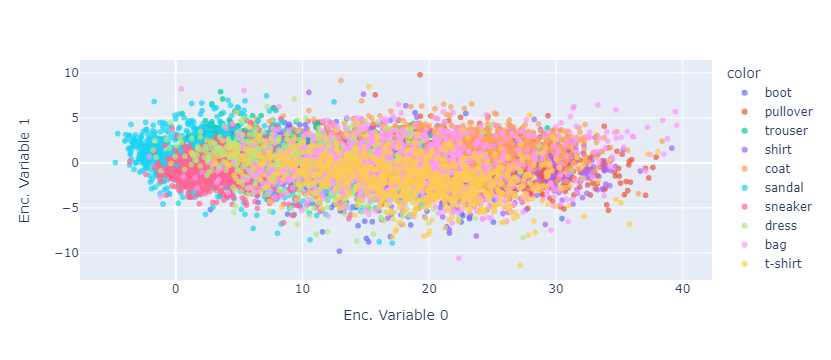

In [50]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

In [51]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[-19.77780142,   6.82800312],
       [ 18.78838055,  11.61290468],
       [ -1.57488934, -20.92257702],
       ...,
       [ -2.53898509,  -7.98664835],
       [ -7.35231457, -18.7590218 ],
       [-12.41019249,   2.37386211]])

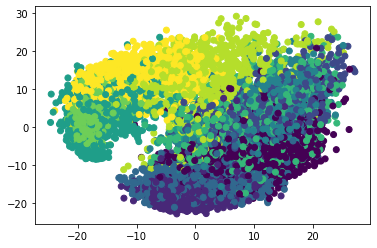

In [52]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



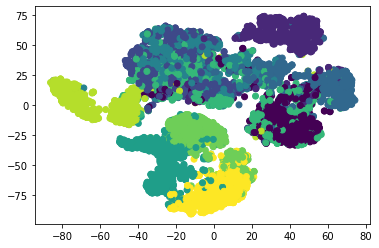

In [53]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

# GAN with FashionMNIST

## Dataset and Dataloader

In [55]:
train_dataset = datasets.FashionMNIST(root='dataset', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='dataset', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [56]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [57]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [58]:
batch_size = 100

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([100, 1, 28, 28])
	 Labels: torch.Size([100])
TEST BATCH SHAPE
	 Data: torch.Size([100, 1, 28, 28])
	 Labels: torch.Size([100])


## Discriminator

In [59]:
class Discriminator(nn.Module):

    def __init__(self, image_size, hidden_size):  
        super().__init__()
        
        self.discriminator = nn.Sequential(
                    nn.Linear(image_size, hidden_size),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_size, hidden_size),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid())
        
    def forward(self, x):
        x = self.discriminator(x)
        return x


## Generator

In [60]:
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        super().__init__()

        self.generator = nn.Sequential(
                nn.Linear(latent_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, image_size),
                nn.Tanh())
        
    def forward(self, x):
        x = self.generator(x)
        return x

In [61]:
image_size = 784
hidden_size = 256
latent_size = 64

In [62]:
discriminator = Discriminator(image_size, hidden_size)
generator = Generator(latent_size, hidden_size, image_size) 

In [63]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


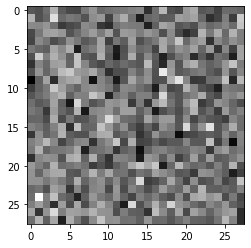

In [64]:
# Generate image before training 
image = torch.randn(2, latent_size)
out = generator(image)
gen_imgs = denorm(out.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')

In [65]:
### Define the loss function
loss_fn = torch.nn.BCELoss()

### Define optimizer both for the discriminator and the generator
lr = 1e-4 # Learning rate   (larger learning rate -> faster convergence)

disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# Move both the encoder and the decoder to the selected device
discriminator.to(device)
generator.to(device)

Generator(
  (generator): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [66]:
def reset_grad():
    disc_optimizer.zero_grad()
    gen_optimizer.zero_grad()

## Training Loop

In [67]:
def train_discriminator(images):
    
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = loss_fn(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = loss_fn(outputs, fake_labels)
    fake_score = outputs
    
    # So essentially, you use the given set of real images and feed it to the discriminator and train 
    # to understand the pattern of the real images.
    # Then, you generate a bunch of fake images and then feed them to the discriminator to train them 
    # to understand the pattern of the fake images.

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad() 
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    disc_optimizer.step()
    
    return d_loss, real_score, fake_score

In [68]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = loss_fn(discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    gen_optimizer.step()
    return g_loss, fake_images

In [69]:
sample_dir = 'samples_from_GAN'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

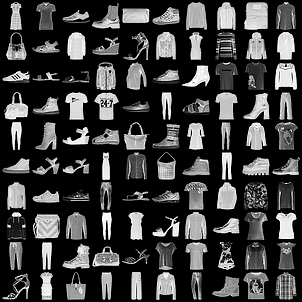

In [70]:
# Save some real images
for images, _ in train_dataloader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_image-0000.png


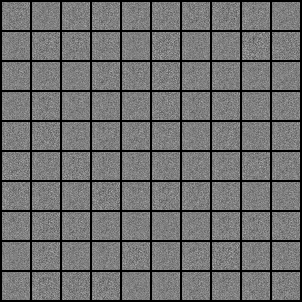

In [71]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_generator_images(index):
    fake_image = generator(sample_vectors)
    fake_image = fake_image.reshape(fake_image.size(0), 1, 28, 28)
    fake_fname = 'fake_image-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_image), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_generator_images(0)
Image(os.path.join(sample_dir, 'fake_image-0000.png'))

In [72]:
%%time
num_epochs = 200
total_step = len(train_dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for i, (images, _) in enumerate(train_dataloader):
               
        # Load a batch & transform to vectors
        
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
        
    # Sample and save images
    save_generator_images(epoch+1)

Epoch:  0
Saving fake_image-0001.png
Epoch:  1
Saving fake_image-0002.png
Epoch:  2
Saving fake_image-0003.png
Epoch:  3
Saving fake_image-0004.png
Epoch:  4
Saving fake_image-0005.png
Epoch:  5
Saving fake_image-0006.png
Epoch:  6
Saving fake_image-0007.png
Epoch:  7
Saving fake_image-0008.png
Epoch:  8
Saving fake_image-0009.png
Epoch:  9
Saving fake_image-0010.png
Epoch:  10
Saving fake_image-0011.png
Epoch:  11
Saving fake_image-0012.png
Epoch:  12
Saving fake_image-0013.png
Epoch:  13
Saving fake_image-0014.png
Epoch:  14
Saving fake_image-0015.png
Epoch:  15
Saving fake_image-0016.png
Epoch:  16
Saving fake_image-0017.png
Epoch:  17
Saving fake_image-0018.png
Epoch:  18
Saving fake_image-0019.png
Epoch:  19
Saving fake_image-0020.png
Epoch:  20
Saving fake_image-0021.png
Epoch:  21
Saving fake_image-0022.png
Epoch:  22
Saving fake_image-0023.png
Epoch:  23
Saving fake_image-0024.png
Epoch:  24
Saving fake_image-0025.png
Epoch:  25
Saving fake_image-0026.png
Epoch:  26
Saving fake

In [ ]:
### Save network parameters
### Save the network state

torch.save(discriminator.state_dict(), 'discriminator_parameters.torch')
torch.save(generator.state_dict(), 'generator_parameters.torch')

### Save optimizer parameters
### Save the optimizer state

torch.save(disc_optimizer.state_dict(), 'disc_optimizer_state.torch')
torch.save(gen_optimizer.state_dict(), 'gen_optimizer_state.torch')

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')
plt.show()

In [ ]:
Image(f"./samples_from_GAN/fake_image-0001.png")
Image(f"./samples_from_GAN/fake_image-0050.png")
Image(f"./samples_from_GAN/fake_image-0100.png")
Image(f"./samples_from_GAN/fake_image-0200.png")